In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import os

from utils import *
from PATH import *
from data import *
from train import *
from models import *

from torchinfo import summary

In [2]:
def plot_depth_map(dm, validity_mask):
    validity_mask = validity_mask > 0
    MIN_DEPTH = 0.5
    MAX_DEPTH = min(300, np.percentile(dm, 99))
    dm = np.clip(dm, MIN_DEPTH, MAX_DEPTH)
    dm = np.log(dm, where=validity_mask)

    dm = np.ma.masked_where(~validity_mask, dm)
    dm = dm.squeeze()

    cmap = plt.cm.jet
    cmap.set_bad(color='black')
    plt.imshow(dm, cmap=cmap, vmax=np.log(MAX_DEPTH))

[  0.         5.699858   5.702601 ... 238.54456  238.54796  238.79964 ]
(768, 1024, 1)


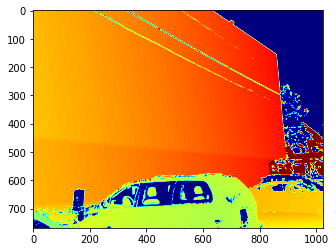

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize( (320, 320) ),     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
target_transform = transforms.Compose([transforms.Resize( (320, 320) )])

dataset = DIODE(TRAIN_PATHS, transform=preprocess, target_transform=target_transform, device=torch.device("cpu"), original=True)
data = dataset[25]
print(np.unique(data['original_label']))
print(data['original_label'].shape)
# plot_depth_map(data['original_label'], data['mask'].reshape(*data['mask'].shape, 1))
plot_depth_map(data['original_label'], np.ones_like(data['original_label']))

In [10]:
def infer(model, filename):
#     from PIL import Image
#     from torchvision import transforms
#     input_image = Image.open(filename)
#     input_image_ = input_image.copy()
#     input_image = input_image.convert("RGB")
#     preprocess = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

#     input_tensor = preprocess(input_image)
    input_tensor = data['rgb']
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    
#     palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
#     colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
#     colors = (colors % 255).numpy().astype("uint8")

#     # plot the semantic segmentation predictions of 21 classes in each color
#     r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
#     r.putpalette(colors)

#     import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(output_predictions.cpu().numpy())    
    plt.figure()    
    plt.imshow(data['original_rgb'])


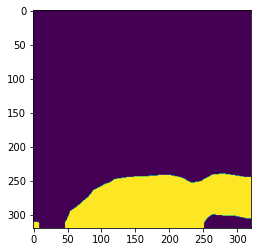

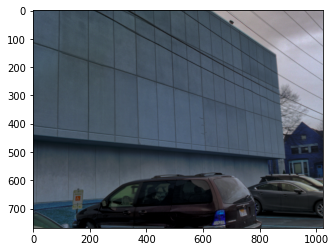

In [11]:
dlcp = RegDeepLab()
dlcp.eval()
dl = dlcp.dl
infer(dl, data['rgb_path'])